# Multiple Routes Analysis

In this section, we are trying to answer a very interesting question: within a city, do different routes experiences the same traffic pattern.

First let's import our moudles

In [1]:
## import system module
import json
import rethinkdb as r
import time
import datetime as dt
import asyncio
from shapely.geometry import Point, Polygon
import random
import pandas as pd
import os
import matplotlib.pyplot as plt

## import custom module
import streettraffic
from streettraffic.map_resource import ultil
from streettraffic.database import TrafficData
from streettraffic import tools
from streettraffic.server import TrafficServer

## Generate Random Routes

In order to accomplish this goal, we need to have a function that generates random points within some geospatial region. Hence the function *get_random_point_in_polygon* is created

In [2]:
def get_random_point_in_polygon(poly):
     (minx, miny, maxx, maxy) = poly.bounds
     while True:
         p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
         if poly.contains(p):
             return p

atlanta_polygon = Polygon([[33.658529, -84.471782], [33.667928, -84.351730], [33.883809, -84.347570], [33.855681, -84.469405]])
sample_points = []
for i in range(100):
    point_in_poly = get_random_point_in_polygon(atlanta_polygon)
    sample_points += [[point_in_poly.x, point_in_poly.y]]

print(TrafficData.format_list_points_for_display(sample_points))

use https://www.darrinward.com/lat-long/ for plotting
33.772547295453,-84.45035187740929
33.75195672973516,-84.46482925078672
33.774602743787526,-84.43633998917504
33.83865854379589,-84.43896082198845
33.78177752621069,-84.35207442541252
33.86573815582652,-84.3628712083673
33.714429167162834,-84.42252739107347
33.74203124360599,-84.43035582804062
33.73123723725762,-84.41215349203813
33.67517978887903,-84.46887795532454
33.839794477361565,-84.39727860196993
33.70403633123844,-84.36027393906868
33.856460492412666,-84.42940942119911
33.72185382050995,-84.36812694165323
33.757160211581244,-84.45022572363617
33.70640448341971,-84.41900338831896
33.71301116092484,-84.42423641998646
33.67202937271758,-84.40833973381407
33.72741682102356,-84.39618906624338
33.714747110133835,-84.42767262960886
33.676246601018086,-84.42165403577157
33.820835969237514,-84.3531931636929
33.6984268478241,-84.36288476124598
33.69642475737589,-84.39649801982384
33.779322657013495,-84.36504839665528
33.85603648087853

Now we simply copy the text above and go to https://www.darrinward.com/lat-long/ for plotting. The result would look like the following picture.

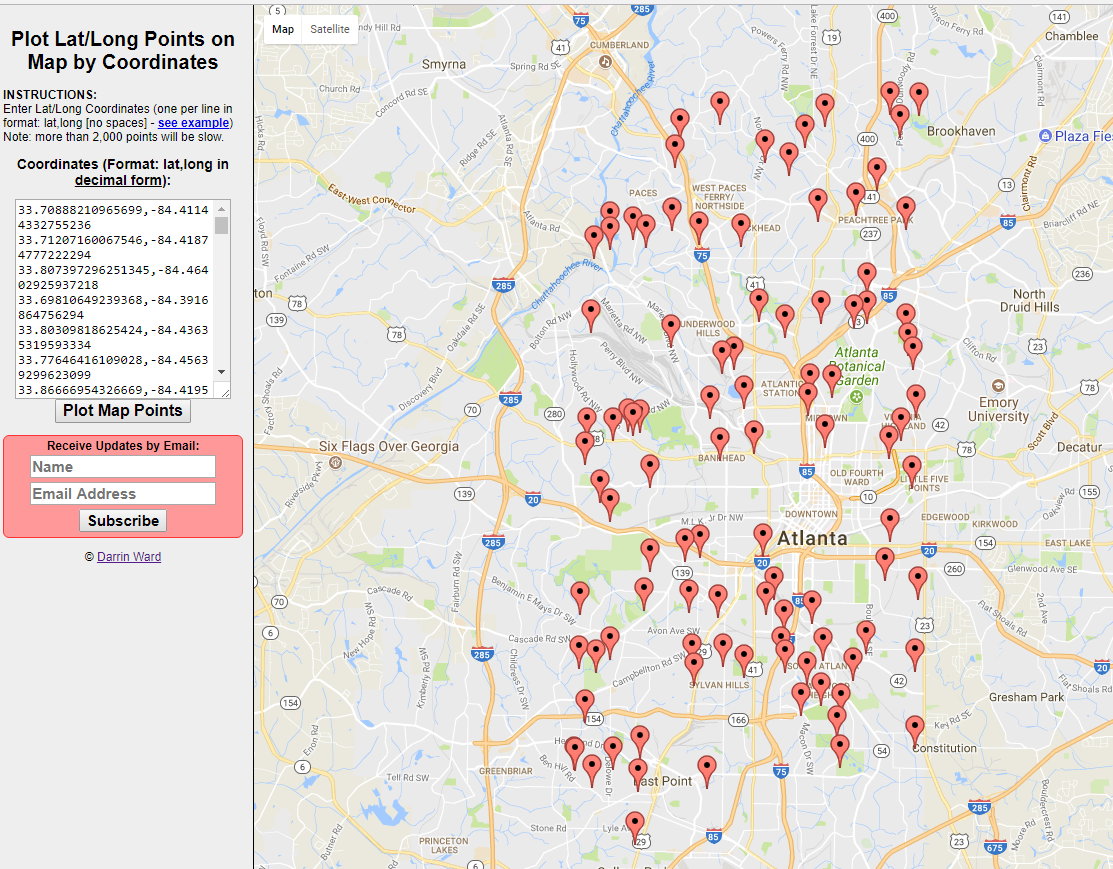

In [3]:
from IPython.display import Image
Image("1.Random_coordinates.PNG")

Now that we know we can generate random points, let's generate random routes. Let sample_route_count = 3, and we can create 3 random routes

In [4]:
sample_route_count = 2
route_obj_collection = []
for i in range(sample_route_count):
    point_in_poly1 = get_random_point_in_polygon(atlanta_polygon)
    point_in_poly2 = get_random_point_in_polygon(atlanta_polygon)
    route_obj_collection += [[
    {
        "lat": point_in_poly1.x,
        "lng": point_in_poly1.y
    },
    {
        "lat": point_in_poly2.x,
        "lng": point_in_poly2.y
    }
    ]]
    
route_obj_collection_json = json.dumps(route_obj_collection)
print(route_obj_collection_json)

[[{"lat": 33.861940334851184, "lng": -84.37419061236831}, {"lat": 33.72926405184585, "lng": -84.3549310954443}], [{"lat": 33.686850158347085, "lng": -84.39145246923371}, {"lat": 33.812991013034825, "lng": -84.42425212075518}]]


## Use the web UI

Copy the above result and paste it in the web UI at /#/Main/RouteLab

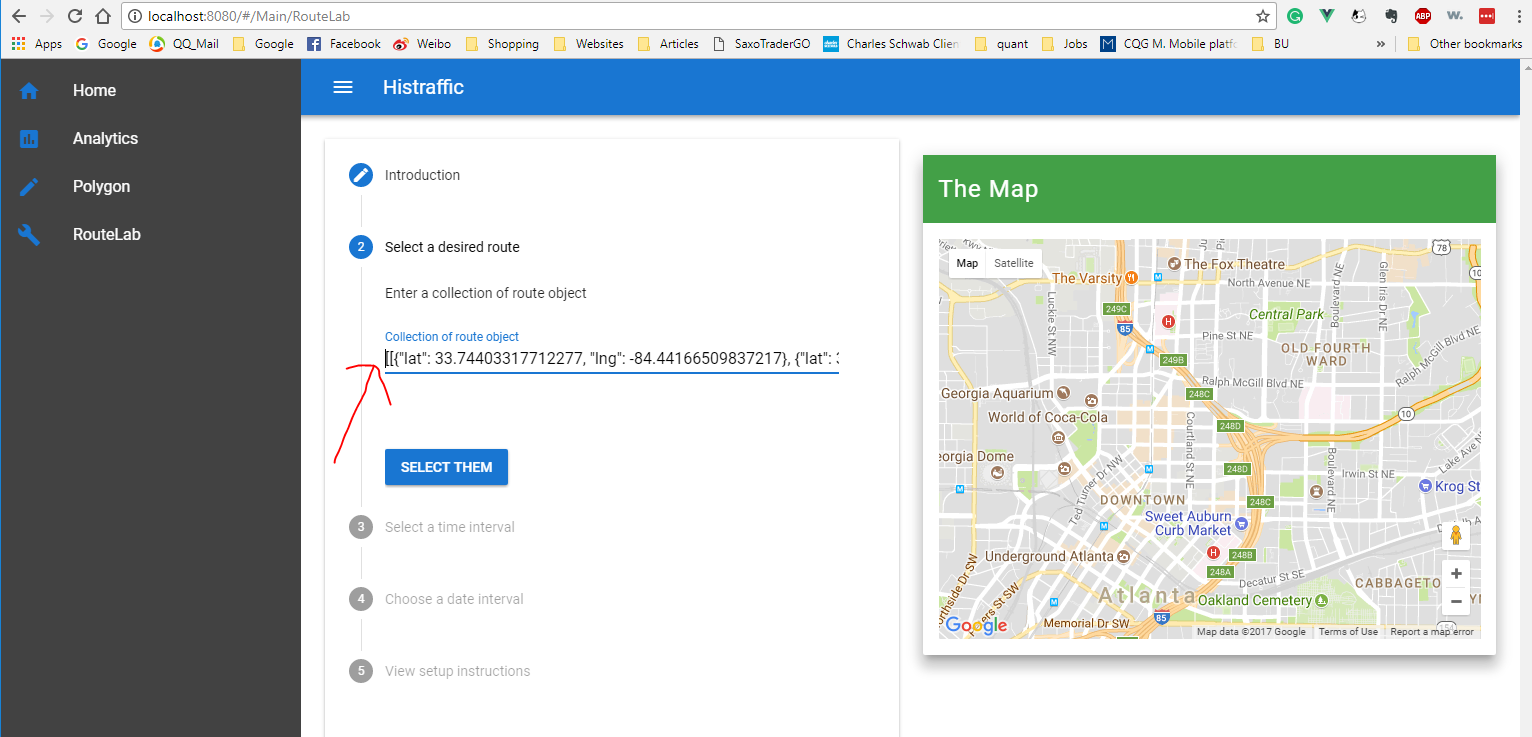

In [5]:
Image("2.route_obj_collection_json.PNG")

Then, select a time interval, date interval and click query data. You may go to the Rethinkdb Web UI to make sure your query is actually getting executed.

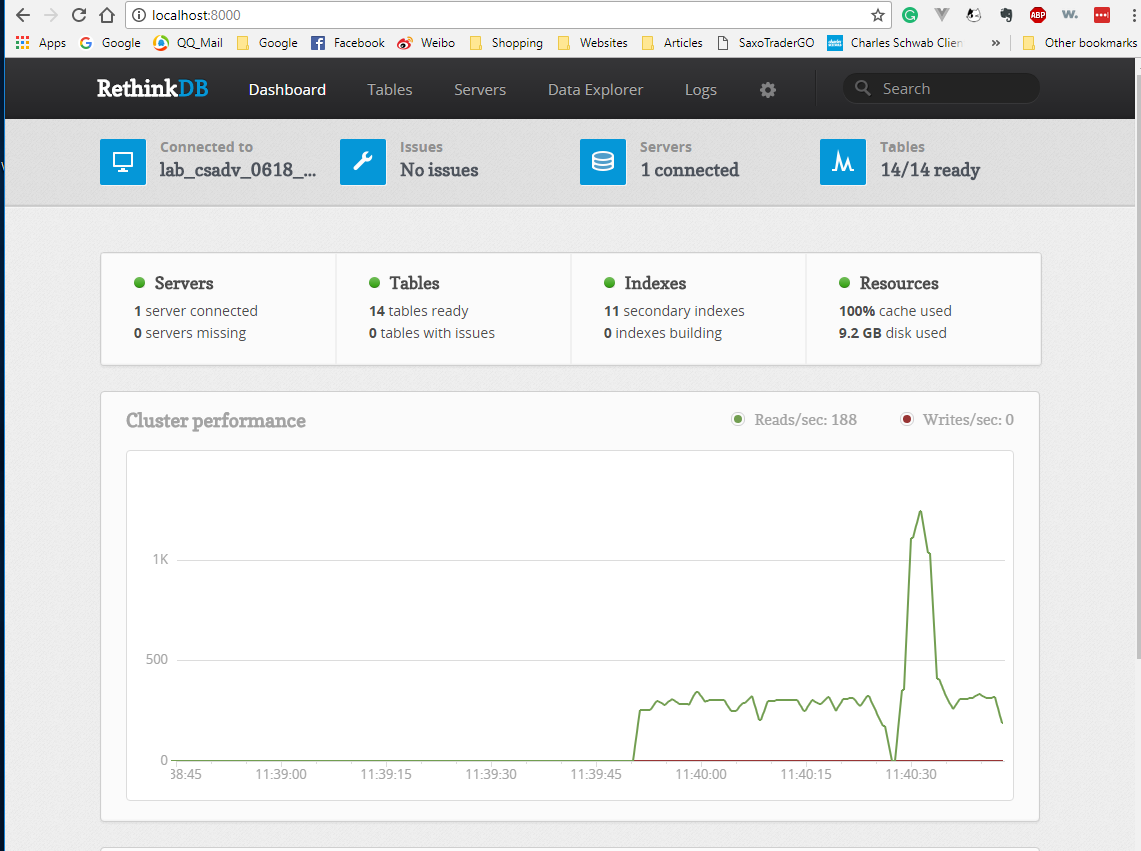

In [6]:
Image("3.Rethinkdb_UI.PNG")

When it's done, simpy click COPY TO CLIPBOARD button to copy the result.

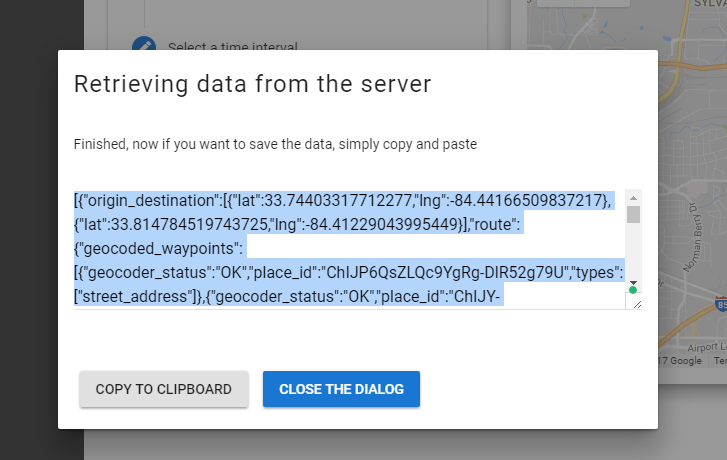

In [7]:
Image("4.Copy_to_clipboard.PNG")

Then create a test.json file and store it in the same directory as the this file.

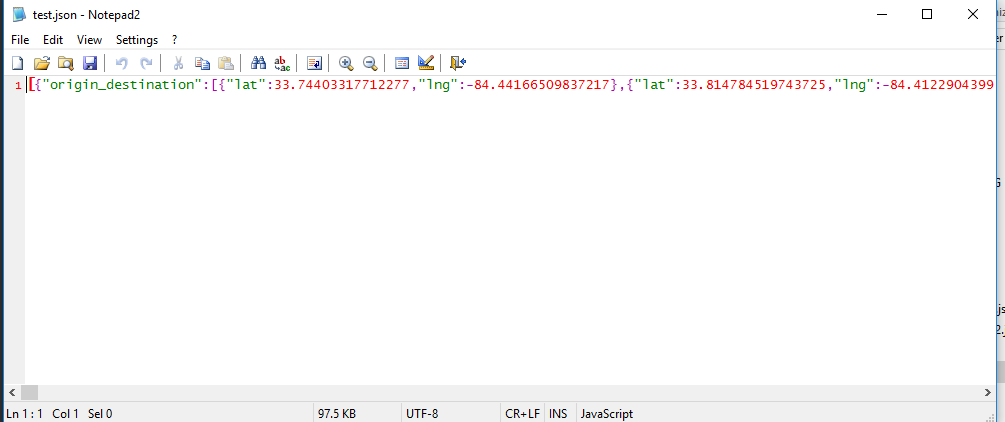

In [8]:
Image("5.Save_the_json.PNG")

## Analyzing data

First load the json, and build an appropirate dataframe for it.

In [9]:
# load the test.json
with open('test.json') as f:
    route_traffic_pattern_collection = json.load(f)

# create a function that takes an overview_path and generate the distance 
def overview_path_distance(overview_path):
    """
    This function extracts the longest_n routes in route_traffic_pattern_collection
    """
    distance = 0
    for i in range(len(overview_path)-1):
        point1 = overview_path[i]
        point2 = overview_path[i+1]
        distance += ultil.get_distance([point1['lat'], point1['lng']], [point2['lat'], point2['lng']])
    return distance

# now we build the dataframe
df = pd.DataFrame(index = [json.dumps(item['origin_destination']) for item in route_traffic_pattern_collection])
df['distance (in meters)'] = [overview_path_distance(item['route']['routes'][0]['overview_path']) for item in route_traffic_pattern_collection]
for i in range(len(route_traffic_pattern_collection[0]['chartLabel'])):
    df[route_traffic_pattern_collection[0]['chartLabel'][i]] = [item['chartData'][i] for item in route_traffic_pattern_collection]

df.sort_values(by='distance (in meters)')

df

,distance (in meters),2:00:00 PM,2:30:00 PM,3:00:00 PM,3:30:00 PM,4:00:00 PM,4:30:00 PM
"[{""lat"": 33.74403317712277, ""lng"": -84.44166509837217}, {""lat"": 33.814784519743725, ""lng"": -84.41229043995449}]",15670.045708,1.929545,2.132554,2.142615,1.570277,2.147405,2.091632
"[{""lat"": 33.69844012187879, ""lng"": -84.41874704102915}, {""lat"": 33.66776541693119, ""lng"": -84.39892665607002}]",4722.955757,0.260154,0.294129,0.283105,0.342374,0.282970,0.299356


In [10]:
# remove the 'distance (in meters)' column and then we can do analysis
del df['distance (in meters)']
df

,2:00:00 PM,2:30:00 PM,3:00:00 PM,3:30:00 PM,4:00:00 PM,4:30:00 PM
"[{""lat"": 33.74403317712277, ""lng"": -84.44166509837217}, {""lat"": 33.814784519743725, ""lng"": -84.41229043995449}]",1.929545,2.132554,2.142615,1.570277,2.147405,2.091632
"[{""lat"": 33.69844012187879, ""lng"": -84.41874704102915}, {""lat"": 33.66776541693119, ""lng"": -84.39892665607002}]",0.260154,0.294129,0.283105,0.342374,0.282970,0.299356


In [11]:
# Now we can do all sorts of fun things with it. 
# feel free to comment out the following statement and see various possibilites

#print(df.mean(axis=1))
#print(df.std())
#print(df.median())

# for each route, give me the mean Jamming Factor of all the instant (2:00:00 PM, 2:30:00 PM, ..., 4:30:00 PM)
df.mean(axis=1)

[{"lat": 33.74403317712277, "lng": -84.44166509837217}, {"lat": 33.814784519743725, "lng": -84.41229043995449}]    2.002338
[{"lat": 33.69844012187879, "lng": -84.41874704102915}, {"lat": 33.66776541693119, "lng": -84.39892665607002}]     0.293681
dtype: float64

## Be *Bold* and try 100 routes




In [12]:
## For reproducibility, we executed the following script and store
## route_obj_collection_json
# sample_route_count = 100
# route_obj_collection = []
# for i in range(sample_route_count):
#     point_in_poly1 = get_random_point_in_polygon(atlanta_polygon)
#     point_in_poly2 = get_random_point_in_polygon(atlanta_polygon)
#     route_obj_collection += [[
#     {
#         "lat": point_in_poly1.x,
#         "lng": point_in_poly1.y
#     },
#     {
#         "lat": point_in_poly2.x,
#         "lng": point_in_poly2.y
#     }
#     ]]
# route_obj_collection_json = json.dumps(route_obj_collection)

with open('route_obj_collection_json.json') as f:
    route_obj_collection_json = json.load(f)
    
## after copying and pasting route_obj_collection_json into WEB UI, getting results and load 
## it in route_traffic_pattern_collection, we get this:

with open('route_traffic_pattern_collection.json') as f:
    route_traffic_pattern_collection = json.load(f)
    
df = pd.DataFrame(index = [json.dumps(item['origin_destination']) for item in route_traffic_pattern_collection])
df['distance (in meters)'] = [overview_path_distance(item['route']['routes'][0]['overview_path']) for item in route_traffic_pattern_collection]
for i in range(len(route_traffic_pattern_collection[0]['chartLabel'])):
    df[route_traffic_pattern_collection[0]['chartLabel'][i]] = [item['chartData'][i] for item in route_traffic_pattern_collection]

df2 = df.sort_values(by='distance (in meters)')
df2

,distance (in meters),12:00:00 AM,12:30:00 AM,1:00:00 AM,1:30:00 AM,2:00:00 AM,2:30:00 AM,3:00:00 AM,3:30:00 AM,4:00:00 AM,...,7:00:00 PM,7:30:00 PM,8:00:00 PM,8:30:00 PM,9:00:00 PM,9:30:00 PM,10:00:00 PM,10:30:00 PM,11:00:00 PM,11:30:00 PM
"[{""lat"": 33.837540745856145, ""lng"": -84.38321004222823}, {""lat"": 33.84041170861723, ""lng"": -84.37814868739103}]",679.582290,0.333295,0.473872,0.089451,0.690876,0.087121,0.140903,0.315598,0.144935,0.302212,...,1.382555,1.412485,1.754518,1.321234,1.287130,1.544028,2.033712,1.179426,1.283749,0.866983
"[{""lat"": 33.76071861447145, ""lng"": -84.4606239135076}, {""lat"": 33.76305888512758, ""lng"": -84.45174412604749}]",1295.605563,0.134299,0.110114,0.054877,0.120210,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.449584,1.544073,1.614911,1.121379,1.409471,1.372583,1.151536,1.146934,0.786731,0.766352
"[{""lat"": 33.830758194529714, ""lng"": -84.4117349846184}, {""lat"": 33.829474898090695, ""lng"": -84.39818984321423}]",1642.128932,0.035987,0.000000,0.056986,0.178911,0.000000,0.103107,0.000000,0.000000,0.000000,...,1.994077,1.715990,1.334134,1.800893,1.613595,1.649335,1.557114,1.358429,1.222357,0.132875
"[{""lat"": 33.714104661211486, ""lng"": -84.36203354697636}, {""lat"": 33.72112374509609, ""lng"": -84.37630135806593}]",2373.648698,0.333932,0.101650,0.076970,0.044407,0.025053,0.195810,0.019593,0.013347,0.013347,...,1.463036,1.537145,1.572067,1.362273,1.696244,1.785806,1.425983,1.417431,0.540653,0.017169
"[{""lat"": 33.82427122662855, ""lng"": -84.39817078679258}, {""lat"": 33.83260727666206, ""lng"": -84.41452183952246}]",2630.600222,0.029444,0.000000,0.046625,0.219573,0.000000,0.113589,0.000000,0.000000,0.000000,...,2.166274,1.795888,1.413058,1.752904,1.561649,1.675321,1.532138,1.358355,1.174072,0.108716
"[{""lat"": 33.69902673641063, ""lng"": -84.40172562843809}, {""lat"": 33.72296007222871, ""lng"": -84.39644877703631}]",3338.172865,0.014345,0.198462,0.106786,0.029628,0.164271,0.011606,0.095574,0.055394,0.019113,...,2.307139,2.158688,2.140838,2.333589,2.188651,2.162339,2.148156,2.217564,1.614621,0.212409
"[{""lat"": 33.797401797575475, ""lng"": -84.39651743916527}, {""lat"": 33.808090475950614, ""lng"": -84.3663388241617}]",3784.922603,0.240826,0.121188,0.119444,0.011301,0.213833,0.208231,0.368007,0.005547,0.066232,...,1.225912,0.638509,0.970784,0.761579,0.537685,0.461975,0.679012,0.657184,0.504416,0.301315
"[{""lat"": 33.79210196390622, ""lng"": -84.46386594813326}, {""lat"": 33.82146566204272, ""lng"": -84.45906428209157}]",4346.382264,0.298821,0.122603,0.089012,0.151525,0.334953,0.157690,0.124975,0.295514,0.246658,...,1.709007,1.604659,1.753006,1.170559,0.934995,1.426028,1.438207,1.224938,1.024346,0.532769
"[{""lat"": 33.79823078716639, ""lng"": -84.38786084904422}, {""lat"": 33.78119138938585, ""lng"": -84.36711116305429}]",4445.598573,0.136327,0.084602,0.159383,0.014128,0.002104,0.000000,0.000000,0.125628,0.005805,...,2.933688,2.567082,2.162184,2.157210,1.657971,1.840179,1.376027,1.443882,1.164497,0.125814
"[{""lat"": 33.862124057835075, ""lng"": -84.35517317551545}, {""lat"": 33.8337069825754, ""lng"": -84.37463312286276}]",4448.199099,0.176458,0.236965,0.074155,0.246277,0.023858,0.011765,0.188725,0.183057,0.080002,...,1.196085,1.712621,2.026141,1.523558,1.394499,1.949068,2.079241,1.829662,1.156481,0.836520


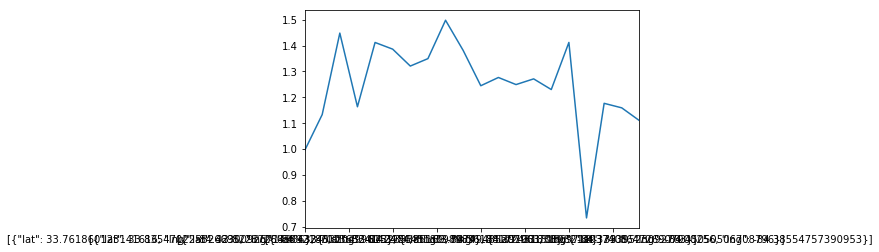

In [13]:
# The following graph shows on average, what is the Jamming Factor throughout 24 hours for those 20 routes.
df3 = df2[-20:]
del df3['distance (in meters)']
df3.mean(axis=1).plot()
plt.show()

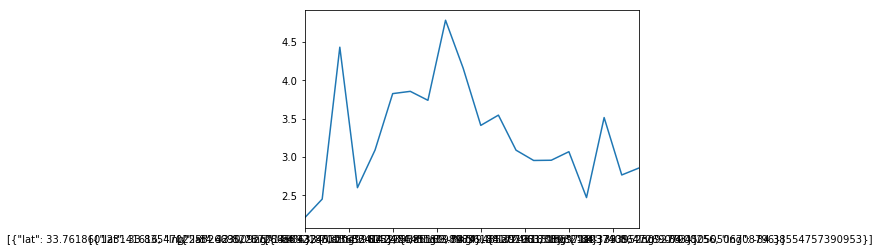

In [14]:
# The following graph extracts the worst jamming factor of each routes
df4 = df2[-20:]
del df4['distance (in meters)']
df4.max(axis=1).plot()
plt.show()

## Conclusion

As we can see in the last graph, for the longest 20 routes, some worst traffic routes are twice as worst as the other, therefore it is reasonable to conclude that within the same city, different routes could experience very different traffic. 